In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from numba import jit
from isingm import *

In [2]:
def animate(data, fname, fps, colormap = 'gray', nice = False):
    fig, ax = plt.subplots()
    im = ax.imshow(data[0], animated = True, cmap= colormap, vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax)

    if nice:
        ax.set_axis_off()                # hides axis ticks and frame
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # remove all padding

    def update(frame):
        im.set_array(data[frame])
        return [im]

    ani = anim.FuncAnimation(fig, update, frames=len(data), interval=1000/fps, blit=False)

    ani.save(fname, fps=fps)

    plt.close(fig)

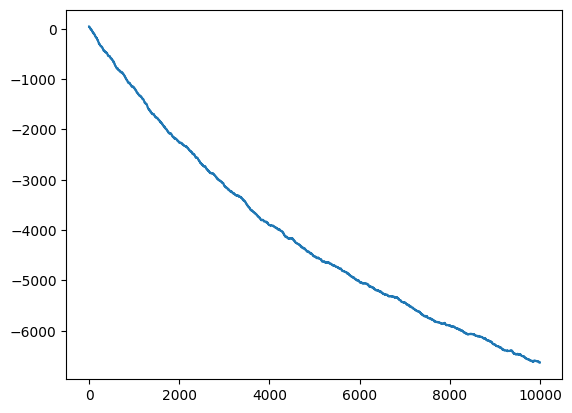

In [3]:
n = 100
a_in = randominitial(n)
steps = 10000
T = 1.9

step, u, a = mc_ising(int(steps), n, 1, T, a_in, frames = 100)
plt.plot(step, u)
plt.show()


animate(a, 'standrad.mp4', 20)

In [4]:
def mc_ising_H(steps:int, n,j,T,a_in, H = np.zeros((n,n), dtype = 'int'), frames = 1000):
    
    save_every = frames
    numsteps = steps/save_every

    a = a_in.copy()

    energies = np.empty(steps)

    E = energy(a,j,H)


    data = []

    for i in range(steps):
        energies[i] = E


        if i % numsteps == 0:
            data.append(a.copy())
        
        x = np.random.randint(0,n)
        y = np.random.randint(0,n)

        b = a.copy()
        b[x,y] *= -1

        dE = -(b[x,y] - a[x,y])*(j*(a[x,(y+1)%n] + a[(x+1)%n,y] + a[x,y-1] + a[x-1,y]) + H[x,y])

        '''if i % 100000 == 0:
            plt.imshow(a)
            plt.title(f"{i}th step")
            plt.show()
        '''
        
        if dE <= 0 or np.random.rand() <= np.exp(-dE * T**(-1)):
            E += dE
            a = b.copy()

    return np.arange(steps), energies, np.array(data), a_in


In [5]:

def mc_ising_Ht(steps:int, n,j,T,a_in, magnetic_field, *args, dtype = 'int', frames = 1000):
    
    save_every = frames
    numsteps = steps/save_every

    a = a_in.copy()

    e_m_f = np.empty((steps,3))

    H = lambda t: magnetic_field(t,n,*args)

    E = energy_H(a,j,H(0))

    M = magnetization(a)
    data = []

    for i in range(steps):
        e_m_f[i] = [E,M,np.sum(H(i))]

        if i % numsteps == 0:
            data.append(a.copy())
        
        x = np.random.randint(0,n)
        y = np.random.randint(0,n)

        b = a.copy()
        b[x,y] *= -1

        dE = -(b[x,y] - a[x,y])*(j*(a[x,(y+1)%n] + a[(x+1)%n,y] + a[x,y-1] + a[x-1,y]) + H(i)[x,y])

        '''if i % 100000 == 0:
            plt.imshow(a)
            plt.title(f"{i}th step")
            plt.show()
        '''
        
        if dE <= 0 or np.random.rand() <= np.exp(-dE * T**(-1)):
            E += dE
            a = b.copy()
            M = magnetization(a)

    return np.arange(steps), e_m_f, np.array(data)

In [6]:
def osc_Ht(t,n,omega, amplitude):
    return np.ones((n,n))*np.sin(omega*t)*amplitude

In [7]:
H = osc_Ht
steps = 300000
n = 100
T = 0.0001
a_in = randominitial(n)
r = n//2
omega = 0.00005
amplitude = 20

steps, emf, a =  mc_ising_Ht(steps, n, 1, T, a_in, H, omega, amplitude, frames = 100)

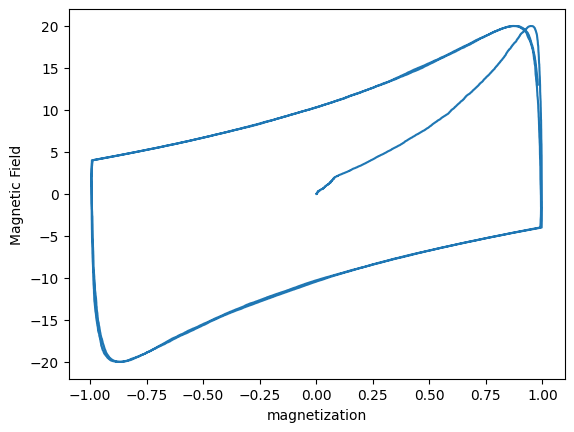

In [8]:
plt.plot(emf[0:,1]/n**2, emf[0:,2]/n**2)
plt.xlabel('magnetization')
plt.ylabel('Magnetic Field')
plt.show()

animate(a, 'osc_H.mp4', 20)

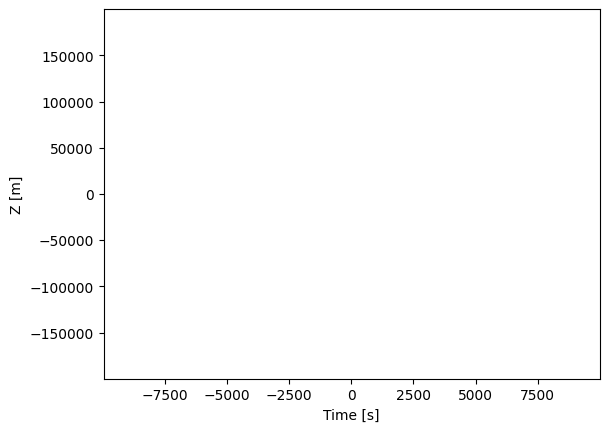

In [9]:
fig, ax = plt.subplots()
x = emf[::100,1]
y = emf[::100,2]
line = ax.plot(x[0],y[0])[0]
ax.set(xlim=[min(x),max(x)], ylim=[min(y),max(y)], xlabel='Time [s]', ylabel='Z [m]')


def draw(frame):
    # for each frame, update the data stored on each artist.
    # update the scatter plot:
    line.set_xdata(x[:frame])
    line.set_ydata(y[:frame])
    # update the line plot:
    return [line]


#ani = anim.FuncAnimation(fig=fig, func=draw, frames=len(x), interval=10)

#ani.save('hysteresis.mp4', fps = 20)

#plt.show()


In [10]:
@jit(nopython=True)
def heis_mc_step(self, a, t, omega):
    x = np.random.randint(n)
    y = np.random.randint(n)

    a_new = a.copy()
    a_new[x,y] = self.random_unit_vector()
    dE = self.site_energy(a_new,x,y,t, omega) - self.site_energy(a,x,y,t, omega)

    if dE <= 0 or np.random.rand() <= np.exp(-dE * T**(-1)):
        return a_new.copy(), dE
    else:
        return a, 0
        
@jit(nopython=True)
def heis_mc(self, steps, omega, frames = 100):

    save_every = steps//frames

    a = self.initial.copy()

    e_m = np.empty((steps, 2))

    data = []

    E = self.total_Energy(a, 0, 0)

    for i in range(steps):
        e_m[i] = [E, magnetization(a)]

        if i % save_every == 0:
            data.append(a.copy())
        
        a, dE = heis_mc_step(self, a, i, omega)

        E += dE

    return np.arange(steps), e_m, np.array(data)
       

In [ ]:
class Heisenberg:
    def __init__(self, n, T, H, *args, j = 1, ordered = False):

        if ordered: 
            self.initial = np.tile([1, 0.0, 0.0], (n, n, 1))
        else:
            self.initial = np.random.normal(size = (n,n,3))
        
        norms = np.linalg.norm(self.initial, axis = -1, keepdims=True)
        self.initial /= norms
        self.j = j
        self.n = n
        self.T = T
        self.N = n*n
        self.magnetic_field = H
        self.H = lambda t: self.magnetic_field(t,n,*args)



    def random_unit_vector(self):
        v = np.random.normal(size=3)
        v /= np.linalg.norm(v)
        return v

    def neighbors(self,a,x,y):
        return [a[x-1,y], a[x,y-1], a[(x+1)%n,y], a[x,(y+1)%n]]

    def site_energy(self,a,x,y,t):
        return -self.j * a[x,y] @ (np.sum(self.neighbors(a,x,y),axis = 0) + self.H(t)[x,y])
    
    def total_Energy(self, a, t):
        energy = 0
        for i in range(self.n):
            for j in range(self.n):
                energy += self.site_energy(a, i, j, t)
        return energy

    def magnetization_pP(self, a):
        return np.sum(a, axis = (0,1)) / self.N  
    

    def mc_step(self, a, t):
        x = np.random.randint(n)
        y = np.random.randint(n)

        a_new = a.copy()
        a_new[x,y] = self.random_unit_vector()
        dE = self.site_energy(a_new,x,y,t) - self.site_energy(a,x,y,t)

        if dE <= 0 or np.random.rand() <= np.exp(-dE * T**(-1)):
            return a_new.copy(), dE
        else:
            return a, 0

        
    def mc(self, steps, frames = 100, omega = 0):

        save_every = steps//frames

        a = self.initial.copy()

        e_m = np.empty((steps, 2))

        data = []

        E = self.total_Energy(a, 0)

        for i in range(steps):
            e_m[i] = [E, magnetization(a)]

            if i % save_every == 0:
                data.append(a.copy())
            
            a, dE = self.mc_step(a, i)

            E += dE

        return np.arange(steps), e_m, np.array(data)
    
    # def mc_step(self, a, t):
    #     return heis_mc_step(self, a, t)
    
    # def mc(self, steps, frames = 100, omega = 0):
    #     return heis_mc(self, steps, frames = frames, omega = omega)


n = 100

map = circle_H(n,n//10)
direction = np.tile([100, 0.0, 0.0], (n, n, 1))

H = map[:,:,None]*direction

h = Heisenberg(n, 0.5, H, 1, ordered = True)

#steps, em, a = h.mc(10000000, omega = 1e-5, frames=1000)

In [45]:
def short_pulse(t,n,r,t0,amp):
    dir = np.tile([amp, 0.0, 0.0], (n, n, 1))
    map = circle_H(n,r)

    if t > t0:
        amp = 0

    dir = np.tile([amp, 0.0, 0.0], (n, n, 1))
    map = circle_H(n,r)

    return map[:,:,None]*dir




In [55]:
n = 100
r = n//10

H = short_pulse

h = Heisenberg(n,T,H,r,n**n,-100, ordered=True)

steps, em, a = h.mc(100000, omega = 1e-4, frames=100)

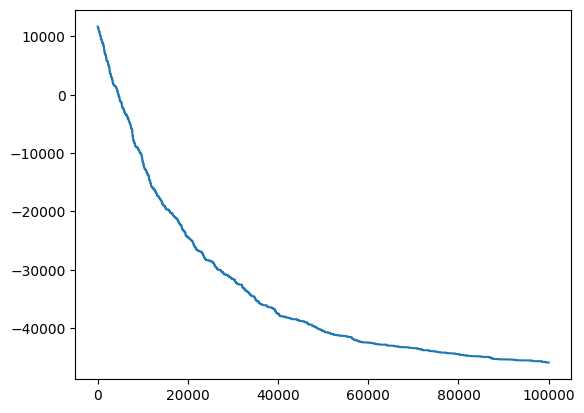

In [56]:
plt.plot(steps, em[:,0])

In [60]:
animate(a[::,:,:,0], 'Heisenberg.mp4', 20, colormap= 'gray')